In [1]:
from google.colab import files
print("Please upload your Benstokes_Bowling.xlsx file again:")
uploaded = files.upload()

Please upload your Benstokes_Bowling.xlsx file again:


Saving Benstokes_Bowling.xlsx to Benstokes_Bowling.xlsx


In [2]:
# STEP 1 — Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [3]:
raw = pd.read_excel("Benstokes_Bowling.xlsx", header=None)
display(raw.head(10))

,0,1,2,3,4,5,6,7,8,9
0,Overs,Mdns,Runs,Wkts,Econ,Ave,SR,Opposition,Ground,Start Date
1,-,-,-,-,-,-,-,v West Indies,The Oval,2011-09-23 00:00:00
2,-,-,-,-,-,-,-,v West Indies,The Oval,2011-09-25 00:00:00
3,3,0,26,0,8.66,-,-,v New Zealand,The Oval,2013-06-25 00:00:00
4,-,-,-,-,-,-,-,v New Zealand,The Oval,2013-06-27 00:00:00
5,3,0,36,0,12,-,-,v Australia,Sydney,2014-02-02 00:00:00
6,2,0,30,0,15,-,-,v West Indies,Bridgetown,2014-03-09 00:00:00
7,-,-,-,-,-,-,-,v West Indies,Bridgetown,2014-03-13 00:00:00
8,3,0,24,2,8,12,9,v New Zealand,Manchester,2015-06-23 00:00:00
9,4,0,29,1,7.25,29,24,v Australia,Cardiff,2015-08-31 00:00:00


In [4]:
fname = "Benstokes_Bowling.xlsx"   # file you uploaded
cutoff = pd.Timestamp('2016-04-03')

In [5]:
# 1) Load (first row is header)
df = pd.read_excel(fname, header=0)
print("Loaded shape:", df.shape)
print("Raw columns:", df.columns.tolist())

Loaded shape: (43, 10)
Raw columns: ['Overs', 'Mdns', 'Runs', 'Wkts', 'Econ', 'Ave', 'SR', 'Opposition', 'Ground', 'Start Date']


In [6]:
# 2) Normalize column names (replace spaces with underscore)
df.columns = [str(c).strip().replace('\n',' ').replace('  ',' ').strip() for c in df.columns]
df.rename(columns=lambda c: c.strip().replace(' ', '_'), inplace=True)
print("Normalized columns:", df.columns.tolist())

Normalized columns: ['Overs', 'Mdns', 'Runs', 'Wkts', 'Econ', 'Ave', 'SR', 'Opposition', 'Ground', 'Start_Date']


In [7]:
# 3) Identify important columns (we expect these from your file)
date_col = next((c for c in df.columns if 'start' in c.lower()), None)
runs_col = next((c for c in df.columns if c.lower().startswith('runs')), None)
wkts_col = next((c for c in df.columns if c.lower().startswith('wkt') or c.lower().startswith('wkts')), None)
econ_col = next((c for c in df.columns if 'econ' in c.lower()), None)
overs_col = next((c for c in df.columns if 'over' in c.lower()), None)

In [8]:
# 4) Basic sanity
if date_col is None:
    raise RuntimeError("Start Date column not found. Check df.columns:", df.columns.tolist())


In [10]:
# 5) Drop non-match rows and parse types
df = df.dropna(subset=[date_col]).copy()
df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True)
for c in [runs_col, wkts_col, econ_col, overs_col]:
    if c is not None:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [11]:
# 6) Tag period
df['Period'] = np.where(df[date_col] < cutoff, 'Pre-2016', 'Post-2016')

In [12]:
# 6) Tag period
df['Period'] = np.where(df[date_col] < cutoff, 'Pre-2016', 'Post-2016')

# 7) Summary (same fields as Brathwaite flow)
summary = df.groupby('Period').agg(
    innings=(runs_col, 'count') if runs_col else (date_col,'count'),
    mean_runs=(runs_col, 'mean') if runs_col else (date_col,'count'),
    median_runs=(runs_col, 'median') if runs_col else (date_col,'count'),
    std_runs=(runs_col, 'std') if runs_col else (date_col,'count'),
    mean_wkts=(wkts_col, 'mean') if wkts_col else (date_col,'count'),
    mean_econ=(econ_col, 'mean') if econ_col else (date_col,'count')
).round(3)

print("\n📊 Ben Stokes Summary (Pre vs Post 2016):")
display(summary.fillna('NA'))


📊 Ben Stokes Summary (Pre vs Post 2016):


,innings,mean_runs,median_runs,std_runs,mean_wkts,mean_econ
Period,,,,,,
Post-2016,24,21.750,20.5,9.076,0.750,8.390
Pre-2016,12,27.833,27.0,6.686,0.667,9.367


In [13]:
# 8) Welch t-test on Economy (if enough numeric rows)
pre = df.loc[df['Period']=='Pre-2016', econ_col].dropna() if econ_col else pd.Series(dtype=float)
post = df.loc[df['Period']=='Post-2016', econ_col].dropna() if econ_col else pd.Series(dtype=float)
if econ_col and len(pre) > 1 and len(post) > 1:
    t_stat, p_val = stats.ttest_ind(pre, post, equal_var=False, nan_policy='omit')
    print(f"\nWelch t-test (Economy pre vs post 2016): t = {t_stat:.3f}, p = {p_val:.4f}")
else:
    print("\n⚠️ Not enough valid Economy rows to run Welch t-test (need >=2 per group) or Econ column missing.")


Welch t-test (Economy pre vs post 2016): t = 0.857, p = 0.4015


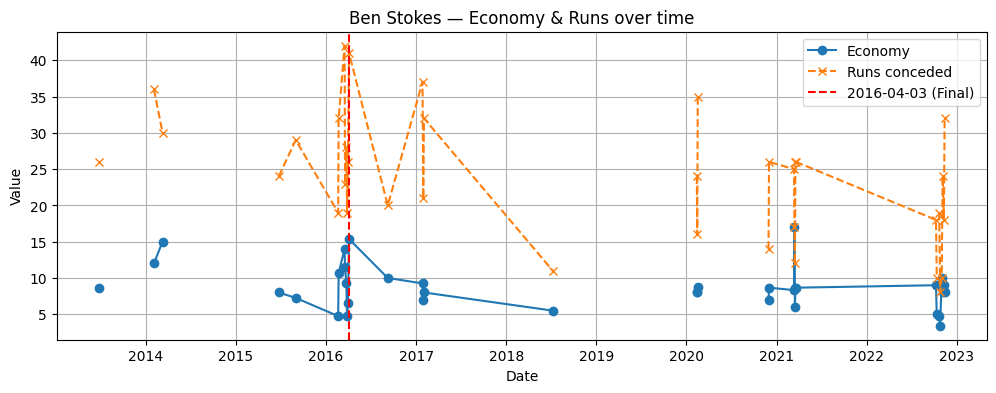

In [14]:
# 9) Plots — Economy & Runs over time
plt.figure(figsize=(12,4))
plot_df = df.sort_values(date_col)
if econ_col and plot_df[econ_col].notna().any():
    plt.plot(plot_df[date_col], plot_df[econ_col], marker='o', linestyle='-', label='Economy')
if runs_col and plot_df[runs_col].notna().any():
    plt.plot(plot_df[date_col], plot_df[runs_col], marker='x', linestyle='--', label='Runs conceded')
plt.axvline(cutoff, color='red', linestyle='--', label='2016-04-03 (Final)')
plt.title("Ben Stokes — Economy & Runs over time")
plt.xlabel("Date"); plt.ylabel("Value"); plt.legend(); plt.grid(True)
plt.show()

In [15]:
# 10) Save cleaned CSV
outname = "BenStokes_Bowling_Cleaned_header0.csv"
df.to_csv(outname, index=False)
print(f"\nSaved cleaned CSV: {outname}")


Saved cleaned CSV: BenStokes_Bowling_Cleaned_header0.csv
